# Anexo 2: Notebook FFT
El objetivo de este notebook es demostrar el uso de FFT y la importancia de la mitigación del spectral leakage.

## FFT
La FFT (Transformada Rápida de Fourier) es un algoritmo que resuelve una DFT (Discrete Fourier Transform). Para su utilización se tiene un vector de entrada y uno de salida de igual longitud. Este algoritmo es de suma utilidad para pasar del dominio temporal al frecuencial y viceversa.

### Resolución Espectral
Se le llama “bin“ a cada posición del vector de salida. Cada uno de estos representa una porción del espectro. El número de bins en la salida de la FFT es igual al número de muestras de la señal de entrada. Por ejemplo, si la señal de entrada tiene 1024 puntos, la de salida tendrá 1024 bins.

Los primeros bins representan las frecuencias más bajas, empezando desde 0 Hz, mientras que los últimos bins contienen información de las frecuencias más altas, hasta la frecuencia de Nyquist (la mitad de la frecuencia de muestreo).

Cada bin corresponde a una frecuencia específica, y la distancia entre las frecuencias de dos bins consecutivos es la resolución en frecuencia, calculada como Δf= N / fs, donde fs es la frecuencia de muestreo y N es el número de muestras (o bins).

### Problemas de la FFT
Según la teoría de la transformada de Fourier, cuando se tienen señales periódicas, entonces la transformada de Fourier tendrá un espectro de líneas (frecuencia fundamental y armónicos), en cambio cuando se trata de una señal no periódica, tiene un espectro continuo. Sin embargo, esto es cierto cuando se hace un análisis desde tiempo -∞ a +∞, lo cual es un caso ideal e imposible de almacenar dentro del microcontrolador. Por lo tanto, por más que se trabaje con señales periódicas, su espectro no será de líneas. De todos modos, la FFT ya tiene en cuenta este efecto e intenta reducirlo considerando que lo que recibe como señal de entrada tiene una cantidad entera de ciclos.

Sin embargo, yendo a un caso real es casi imposible tomar una muestra que contenga una cantidad entera de ciclos, sumado a esto hay presencia de ruido eléctrico, hay ruido de cuantización y al mismo tiempo es posible que la señal a medir no sea perfectamente periódica. Debido a todos estos efectos combinados, hace que en el espectro veamos lo que se llama Specrtal Leackage (fuga espectral). Esto es lo que informalmente se conoce como “piso de ruido”.

Una manera de reducirlo considerablemente es mediante el uso de ventanas. Las ventanas permiten reducir el efecto de fuga espectral cuando la señal de entrada no tiene una cantidad entera de ciclos. Otra medida importante a considerar es que a medida que la FFT analice más cantidad de ciclos, bajará el piso de ruido pero en contrapartida será más lento el procesamiento.

## Simulaciones
Para entender mejor todo lo anterior, propongo hacer algunas simulaciones, en donde se verificará la realización de FFT y la importancia de mitigar el spectrak lakage.

### Inclusión de Librerías y preparación del enterno de trabajo
Para el uso de este notebook hay que inlcuir los módulos correspondientes a las herramientas de cálculo y gráficos de señales

In [ ]:
!pip install scipy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal.windows import flattop

### Señales temporales
En primer lugar se plotean las señales a analizar.
Para ello preparamos la función matemática:
f(t) = sen(w1 t) + sen(w2 t) + sen(w3 t) + sen(w4 t)

E implementamos en el código
* Señal 1: 4   ciclos de la señal f(t)
* Señal 2: 4.3 ciclos de la señal f(t)
* Señal 3: 4.3 ciclos de la señal f(t) aplicando una ventana flattop

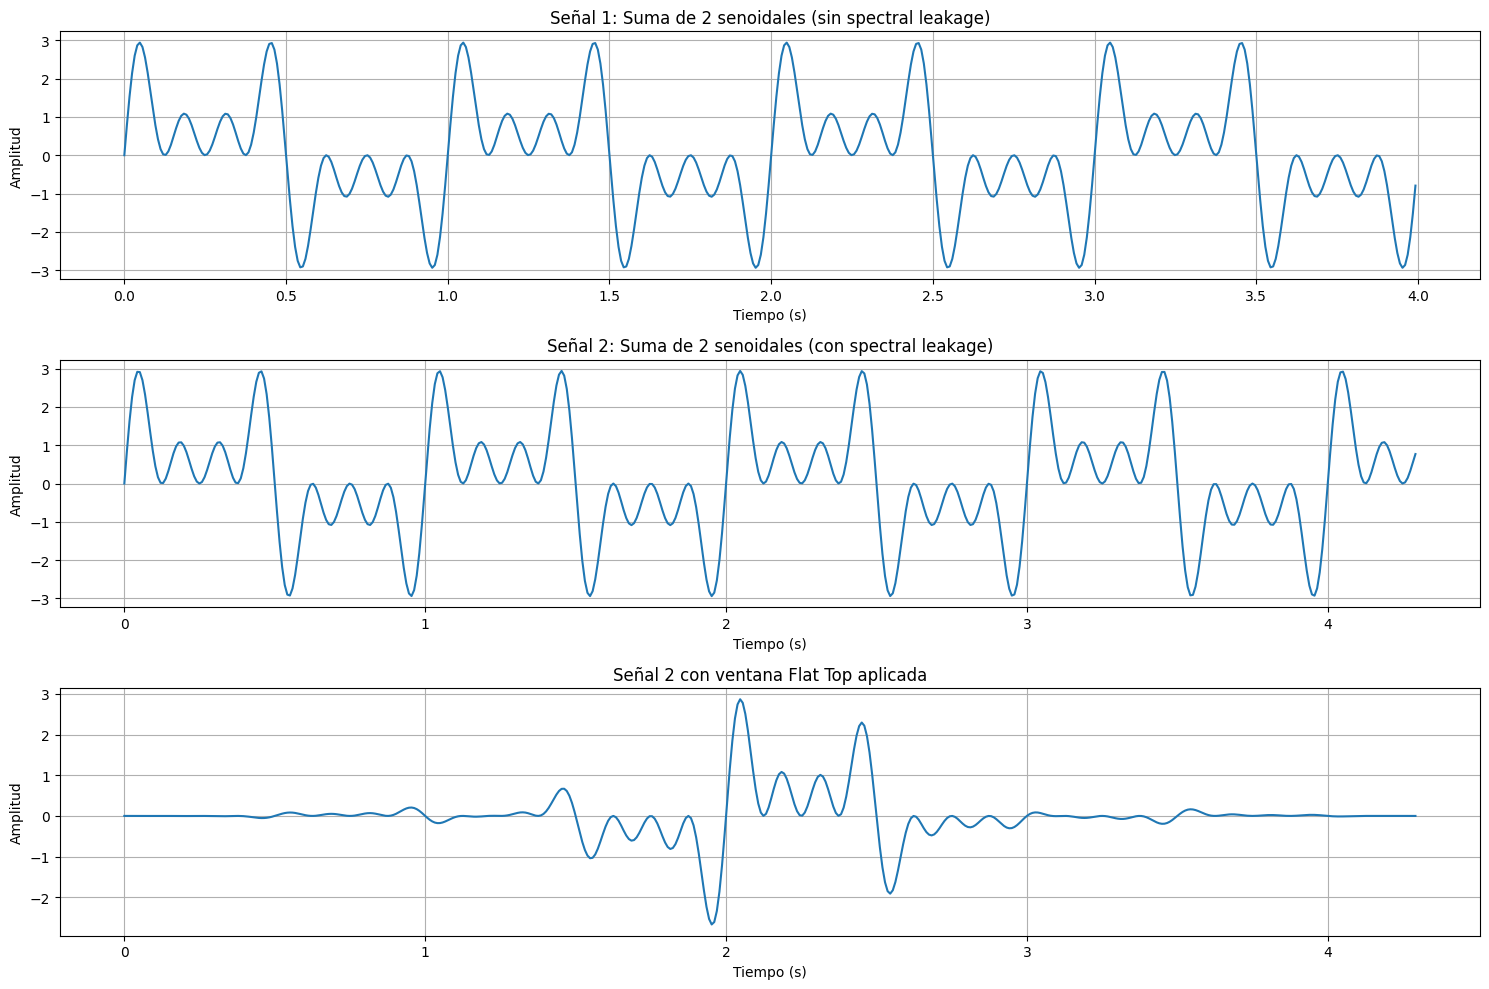

In [ ]:
# Parámetros
fs = 500                      # Frecuencia de muestreo (Hz)
f1, f2, f3, f4 = 1, 3, 5, 7   # Frecuencias de las senoidales (Hz)

t1 = np.linspace(0, 4, fs, endpoint=False)  # Vector de tiempo de 5 segundo
t2 = np.linspace(0, 4.3, fs, endpoint=False)  # Vector de tiempo de 4.8 segundo

# Señal 1: Suma de 2 senoidales (ciclos enteros)
signal1 = np.sin(2 * np.pi * f1 * t1) + np.sin(2 * np.pi * f2 * t1) + np.sin(2 * np.pi * f3 * t1) + np.sin(2 * np.pi * f4 * t1)

# Señal 2: Suma de 2 senoidales (cantidad de ciclos no enteros)
signal2 = np.sin(2 * np.pi * f1 * t2) + np.sin(2 * np.pi * f2 * t2) + np.sin(2 * np.pi * f3 * t2) + np.sin(2 * np.pi * f4 * t2)

# Señal 3: Aplicando ventana Flat Top a la señal 2
window = flattop(len(t2))  # Ventana Flat Top
signal3 = signal2 * window

# Gráficos de las señales en el dominio del tiempo
plt.figure(figsize=(15, 10))

# Señal 1 (sin spectral leakage)
plt.subplot(3, 1, 1)
plt.plot(t1, signal1)
plt.title('Señal 1: Suma de 2 senoidales (sin spectral leakage)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()

# Señal 2 (con spectral leakage)
plt.subplot(3, 1, 2)
plt.plot(t2, signal2)
plt.title('Señal 2: Suma de 2 senoidales (con spectral leakage)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()

# Señal 3 (con ventana Flat Top aplicada)
plt.subplot(3, 1, 3)
plt.plot(t2, signal3)
plt.title('Señal 2 con ventana Flat Top aplicada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()

plt.tight_layout()
plt.show()

### FFT de la señal 1

Si analiamos dicha señal se puede ver que si bien el espectro no es perfectamente de líneas, puede diferenciarse con claridad a cada armónico. Las líneas punteadas representan cada componente frecuencial detectada

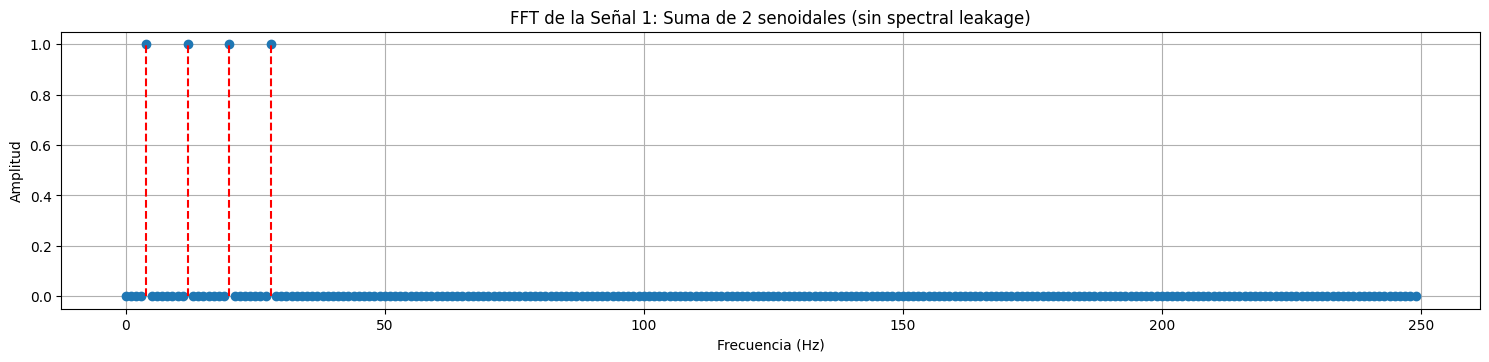

In [ ]:
# FFT de las señales
fft_signal1 = fft(signal1)
fft_signal2 = fft(signal2)
fft_signal3 = fft(signal3)

# Frecuencias asociadas a los bins
frequencies = np.fft.fftfreq(len(t1), 1/fs)

# Magnitud de la FFT (solo positiva)
def magnitude(fft_data):
    return 2.0 / len(t1) * np.abs(fft_data[:len(t1) // 2])

# Gráficos de la FFT
plt.figure(figsize=(15, 10))

# FFT de la Señal 1 (sin spectral leakage)
plt.subplot(3, 1, 1)
plt.plot(frequencies[:len(t1)//2], magnitude(fft_signal1),'o')
x = frequencies[:len(t1)//2]
y = magnitude(fft_signal1)
for xi, yi in zip(x, y):
    plt.plot([xi, xi], [0, yi], 'r--')
plt.title('FFT de la Señal 1: Suma de 2 senoidales (sin spectral leakage)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid()

plt.tight_layout()
plt.show()

### FFT de la señal 2: Spectral leakage
Al analizar esta señal podemos ver que también de manera aproximada pueden discriminarse los armónicos, sin embargo, se perdió completamente la relación entre amplitudes. Por ejemplo, da la sensación que los tonos tienen diferentes amplitudes y en relaidad no es así. De hecho, ninguno de los tonos llega a amplitud unitaria.

Por otro lado, si bien pueden discriminarse los armónicos a simple vista, puede verse que el resultado matemático ya deja de ser un espectro de líneas y pasa a ser un espectro continuo (la FFT arroja más de una línea punteada por armónico). A esto se le llama spectral leakage.

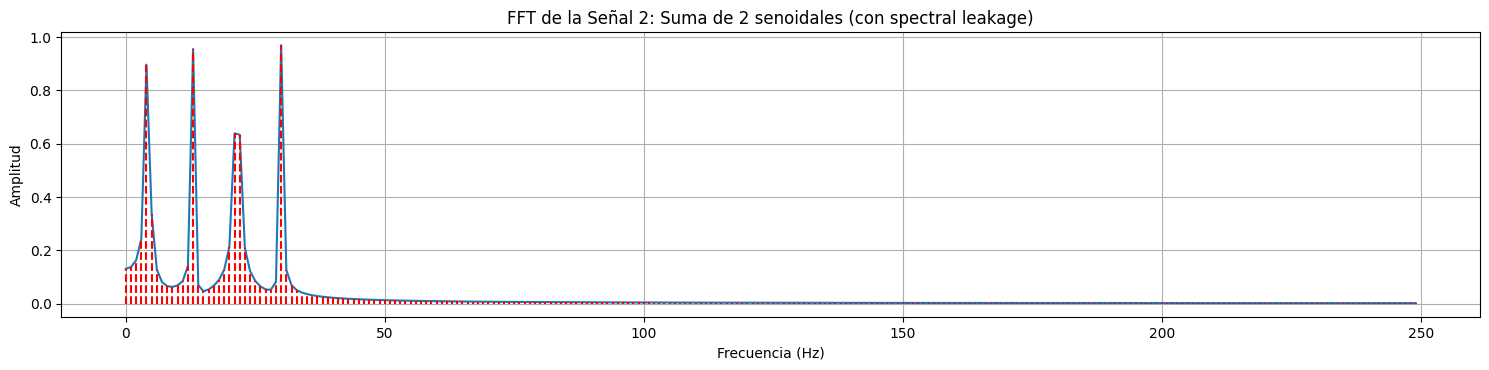

In [ ]:
# FFT de la Señal 2 (con spectral leakage)
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 2)
plt.plot(frequencies[:len(t2)//2], magnitude(fft_signal2))
x = frequencies[:len(t2)//2]
y = magnitude(fft_signal2)
for xi, yi in zip(x, y):
    plt.plot([xi, xi], [0, yi], 'r--')

plt.title('FFT de la Señal 2: Suma de 2 senoidales (con spectral leakage)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid()

plt.tight_layout()
plt.show()

### Señal 3: Ventaneo
Para resolver el problema de la señal anterior se utiliza la técnica del "ventaneo". Esto consiste en deformar a la señal temporal con una "ventana" la cual permite obtener una FFT realzando una característica deseada. Por ejemplo en nuestro caso nos interesa ser precisos en la amplitud. Por eso se eligió una ventana "flat top". De esta manera, si bien seguimos teniendo spectral leakage, se aprecia con claridad que todos 4 armónicos de igual amplitud.

Sin embargo, por ejemplo existen otras ventanas que dan mejor detalle en otro parámetro. Por ejemplo la ventana hamming es muy recomendada para recuperar lo mejor posible la resolución espectral.

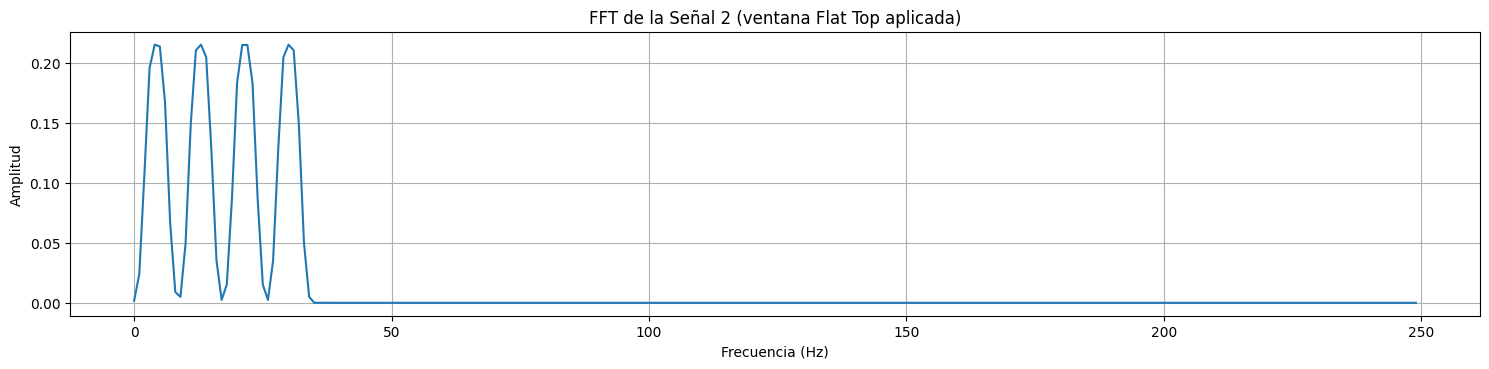

In [ ]:
# FFT de la Señal 3 (con ventana Flat Top aplicada)
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 3)
plt.plot(frequencies[:len(t2)//2], magnitude(fft_signal3))
plt.title('FFT de la Señal 2 (ventana Flat Top aplicada)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid()

plt.tight_layout()
plt.show()

### Señal 3 con amplitud corregida
En el gráfico anterior puede verse que si bien las amplitudes entre los amróncios es correcta (todos tienen la misma amplitud), el valor de cada una de ellas era de 0.2, cuando e relaidad debería ser 1.

Por eso es que luego de aplicar una ventana es importante corregirle la amplitud antes de interpretar los datos. En el caso de la ventana flattop se hace desnormalizando por el valor medio de la ventana aplicada.

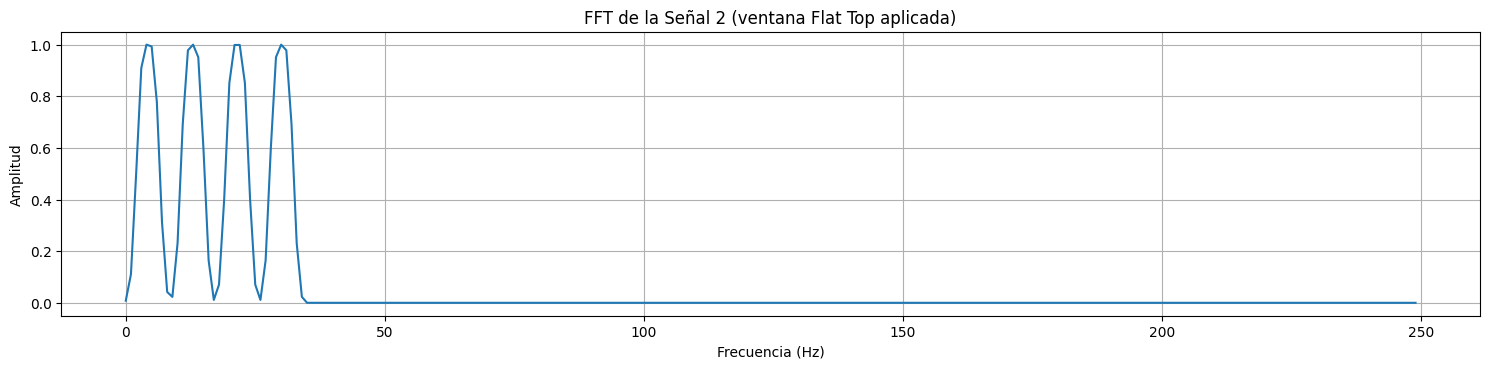

In [ ]:
# FFT de la Señal 3 (con ventana Flat Top aplicada y corrigiendo la amplitud)
correction_factor = np.sum(window) / len(window)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 3)
plt.plot(frequencies[:len(t2)//2], magnitude(fft_signal3)/correction_factor)
plt.title('FFT de la Señal 2 (ventana Flat Top aplicada)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.grid()

plt.tight_layout()
plt.show()

Como conclusión, siempre que se utilice el algoritmo FFT es muy recomendable tener en cuenta la mitigación del desparramo espectral. Por otro lado, siempre que se pueda, es mejor procesar más cantidad de ciclos.